## House Prices: Advanced Regression Techniques 
In this competitions we have 79 explanatory variables describing aspects of residential homes in Ames, Iowa. The goal is to predict the prices of these houses.

The metric to calculate the accuracy of predictions is Root Mean Squared Logarithmic Error (it penalizes an under-predicted estimate greater than an over-predicted estimate).

The RMSLE is calculated as

$$
\epsilon = \sqrt{\frac{1}{n} \sum_{i=1}^n (\log(p_i + 1) - \log(a_i+1))^2 }
$$

Where:

\\(\epsilon\\) is the RMSLE value (score);
\\(n\\) is the number of observations;
\\(p_i\\) is prediction;
\\(a_i\\) is the actual response for \\(i\\);
\\(\log(x)\\) is the natural logarithm of \\(x\\)

At first I explore the data, fill missing values and visualize some features, then I try several models for prediction.

1. [Data exploration](#datex)

2. [Dealing with missing data](#datmis)
    
3. [Data visualization](#datvis)
    
4. [Data preparation](#datprep)

5. [Model](#model)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import rcParams
import xgboost as xgb
%matplotlib inline 
sns.set_style('whitegrid')

import scipy.stats as stats
from scipy import stats
from scipy.stats import pointbiserialr, spearmanr, skew, pearsonr

from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn import linear_model

## <a name="datex">Data exploration</a>

In [2]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-n

In [4]:
data.describe(include='all')

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
count,1460.000000,1460.000000,1460,1201.000000,1460.000000,1460,91,1460,1460,1460,...,1460.000000,7,281,54,1460.000000,1460.000000,1460.000000,1460,1460,1460.000000
unique,NaN,NaN,5,NaN,NaN,2,2,4,4,2,...,NaN,3,4,4,NaN,NaN,NaN,9,6,NaN
top,NaN,NaN,RL,NaN,NaN,Pave,Grvl,Reg,Lvl,AllPub,...,NaN,Gd,MnPrv,Shed,NaN,NaN,NaN,WD,Normal,NaN
freq,NaN,NaN,1151,NaN,NaN,1454,50,925,1311,1459,...,NaN,3,157,49,NaN,NaN,NaN,1267,1198,NaN
mean,730.500000,56.897260,NaN,70.049958,10516.828082,NaN,NaN,NaN,NaN,NaN,...,2.758904,NaN,NaN,NaN,43.489041,6.321918,2007.815753,NaN,NaN,180921.195890
std,421.610009,42.300571,NaN,24.284752,9981.264932,NaN,NaN,NaN,NaN,NaN,...,40.177307,NaN,NaN,NaN,496.123024,2.703626,1.328095,NaN,NaN,79442.502883
min,1.000000,20.000000,NaN,21.000000,1300.000000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,1.000000,2006.000000,NaN,NaN,34900.000000
25%,365.750000,20.000000,NaN,59.000000,7553.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,5.000000,2007.000000,NaN,NaN,129975.000000
50%,730.500000,50.000000,NaN,69.000000,9478.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,6.000000,2008.000000,NaN,NaN,163000.000000
75%,1095.250000,70.000000,NaN,80.000000,11601.500000,NaN,NaN,NaN,NaN,NaN,...,0.000000,NaN,NaN,NaN,0.000000,8.000000,2009.000000,NaN,NaN,214000.000000


In [5]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


Quite a lot of variables. Many categorical variables, which makes analysis more complex. And a lot of missing values. Or are they merely missing values? There are many features for which NaN value simply means an absense of the feature (for example, no Garage).

## <a name="datmis">Dealing with missing data</a>

At first, lets see which columns have missing values.

In [6]:
data[data.columns[data.isnull().sum() > 0].tolist()].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 19 columns):
LotFrontage     1201 non-null float64
Alley           91 non-null object
MasVnrType      1452 non-null object
MasVnrArea      1452 non-null float64
BsmtQual        1423 non-null object
BsmtCond        1423 non-null object
BsmtExposure    1422 non-null object
BsmtFinType1    1423 non-null object
BsmtFinType2    1422 non-null object
Electrical      1459 non-null object
FireplaceQu     770 non-null object
GarageType      1379 non-null object
GarageYrBlt     1379 non-null float64
GarageFinish    1379 non-null object
GarageQual      1379 non-null object
GarageCond      1379 non-null object
PoolQC          7 non-null object
Fence           281 non-null object
MiscFeature     54 non-null object
dtypes: float64(3), object(16)
memory usage: 216.8+ KB


Now I create lists of columns with missing values in train and test. Then I use list comprehension to get a list with columns which are present in test but not in train. Then I find the columns which are present in train but not in test.

In [7]:
list_data = data.columns[data.isnull().sum() > 0].tolist()
list_test = test.columns[test.isnull().sum() > 0].tolist()
test[list(i for i in list_test if i not in list_data)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 15 columns):
MSZoning        1455 non-null object
Utilities       1457 non-null object
Exterior1st     1458 non-null object
Exterior2nd     1458 non-null object
BsmtFinSF1      1458 non-null float64
BsmtFinSF2      1458 non-null float64
BsmtUnfSF       1458 non-null float64
TotalBsmtSF     1458 non-null float64
BsmtFullBath    1457 non-null float64
BsmtHalfBath    1457 non-null float64
KitchenQual     1458 non-null object
Functional      1457 non-null object
GarageCars      1458 non-null float64
GarageArea      1458 non-null float64
SaleType        1458 non-null object
dtypes: float64(8), object(7)
memory usage: 171.1+ KB


In [8]:
data[list(i for i in list_data if i not in list_test)].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 1 columns):
Electrical    1459 non-null object
dtypes: object(1)
memory usage: 11.5+ KB


No value in the following columns probably means absense of it:

- Alley;
- MasVnrType (Masonry veneer type) and MasVnrArea (its area);
- BsmtQual and BsmtCond (two parameters of basement);
- BsmtExposure (Walkout or garden level basement walls);
- BsmtFinType1 and BsmtFinType2 (Quality of basement finished area) and BsmtFinSF1, BsmtFinSF2 (their area);
- BsmtUnfSF (Unfinished square feet of basement area);
- FireplaceQu (Fireplace quality);
- GarageType, GarageFinish, GarageQual, GarageCond (garage parameters) and GarageYrBlt;
- KitchenQual;
- PoolQC;
- Fence;
- MiscFeature (Miscellaneous feature not covered in other categories);


For other variables missing values could be replaced with most common parameters:

- MSZoning (The general zoning classification);
- Utilities;
- Exterior1st and Exterior2nd (Exterior covering on house);
- KitchenQual;
- Functional (Home functionality rating);
- SaleType;
- Electrical;
- LotFrontage;
- GarageCars and GarageArea;

In [9]:
#Create a list of column to fill NA with "None" or 0.
to_null = ['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'FireplaceQu',
           'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'GarageYrBlt', 'BsmtFullBath', 'BsmtHalfBath',
           'PoolQC', 'Fence', 'MiscFeature']
for col in to_null:
    if data[col].dtype == 'object':

        data[col].fillna('None',inplace=True)
        test[col].fillna('None',inplace=True)
    else:

        data[col].fillna(0,inplace=True)
        test[col].fillna(0,inplace=True)

In [10]:
#Fill NA with common values.
test.loc[test.KitchenQual.isnull(), 'KitchenQual'] = 'TA'
test.loc[test.MSZoning.isnull(), 'MSZoning'] = 'RL'
test.loc[test.Utilities.isnull(), 'Utilities'] = 'AllPub'
test.loc[test.Exterior1st.isnull(), 'Exterior1st'] = 'VinylSd'
test.loc[test.Exterior2nd.isnull(), 'Exterior2nd'] = 'VinylSd'
test.loc[test.Functional.isnull(), 'Functional'] = 'Typ'
test.loc[test.SaleType.isnull(), 'SaleType'] = 'WD'
data.loc[data['Electrical'].isnull(), 'Electrical'] = 'SBrkr'
data.loc[data['LotFrontage'].isnull(), 'LotFrontage'] = data['LotFrontage'].mean()
test.loc[test['LotFrontage'].isnull(), 'LotFrontage'] = test['LotFrontage'].mean()

There are several additional cases: when a categorical variable is None, relevant numerical variable should be 0. For example if there is no veneer (MasVnrType is None), MasVnrArea should be 0.

In [11]:
data.loc[data.MasVnrType == 'None', 'MasVnrArea'] = 0
test.loc[test.MasVnrType == 'None', 'MasVnrArea'] = 0
test.loc[test.BsmtFinType1=='None', 'BsmtFinSF1'] = 0
test.loc[test.BsmtFinType2=='None', 'BsmtFinSF2'] = 0
test.loc[test.BsmtQual=='None', 'BsmtUnfSF'] = 0
test.loc[test.BsmtQual=='None', 'TotalBsmtSF'] = 0

In [12]:
#And there is only one line where GarageCars and GarageArea is null, but it seems that there is no garage.
test.loc[test.GarageCars.isnull() == True]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
1116,2577,70,RM,50.0,9060,Pave,None,Reg,Lvl,AllPub,...,0,0,None,MnPrv,None,0,3,2007,WD,Alloca


In [13]:
test.loc[test.GarageCars.isnull(), 'GarageCars'] = 0
test.loc[test.GarageArea.isnull(), 'GarageArea'] = 0

## <a name="datvis">Data visualization</a>

At first I'll look into data correlation, then I'll visualize some data in order to see the impact of certain features.

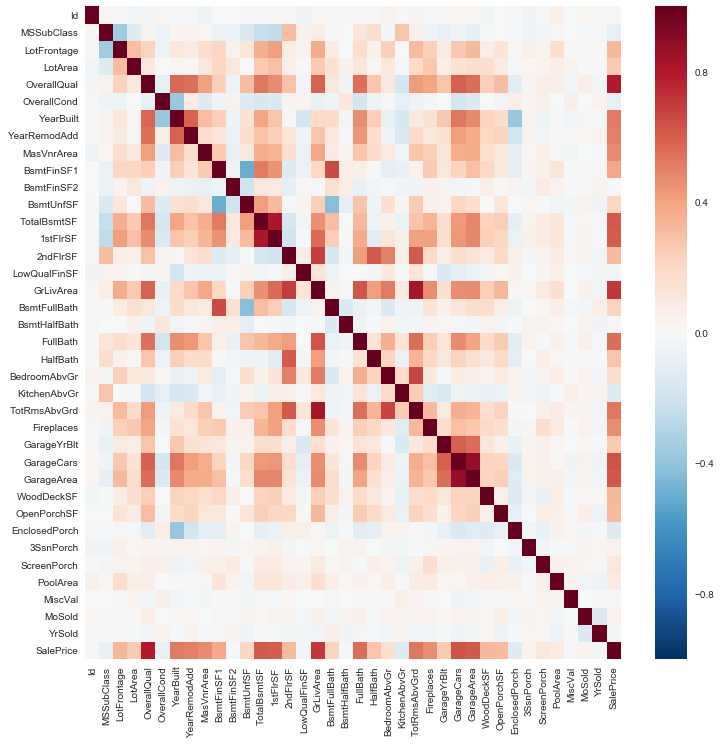

In [14]:
corr = data.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr, vmax=1)

It seems that only several pairs of variables have high correlation. But this chart shows data only for pairs of numerical values. I'll calculate correlation for all variables.

In [15]:
threshold = 0.8 # Threshold value.
def correlation():
    for i in data.columns:
        for j in data.columns[list(data.columns).index(i) + 1:]: #Ugly, but works. This way there won't be repetitions.
            if data[i].dtype != 'object' and data[j].dtype != 'object':
                #pearson is used by default for numerical.
                if abs(pearsonr(data[i], data[j])[0]) >= threshold:
                    yield (pearsonr(data[i], data[j])[0], i, j)
            else:
                #spearman works for categorical.
                if abs(spearmanr(data[i], data[j])[0]) >= threshold:
                    yield (spearmanr(data[i], data[j])[0], i, j)

In [16]:
corr_list = list(correlation())
corr_list

D:\Programs\Anaconda3\lib\site-packages\scipy\stats\stats.py:253: RuntimeWarning: The input array could not be properly checked for nan values. nan values will be ignored.
  "values. nan values will be ignored.", RuntimeWarning)


[(0.85848725676346904, 'Exterior1st', 'Exterior2nd'),
 (-0.89606878858916439, 'BsmtFinType2', 'BsmtFinSF2'),
 (0.81952997500503311, 'TotalBsmtSF', '1stFlrSF'),
 (0.82548937430884295, 'GrLivArea', 'TotRmsAbvGrd'),
 (0.88247541428146214, 'GarageCars', 'GarageArea'),
 (-0.99999111097112325, 'PoolArea', 'PoolQC'),
 (0.9028952966055307, 'MiscFeature', 'MiscVal')]

This is a list of highly correlated features. They aren't surprising and none of them should be removed.

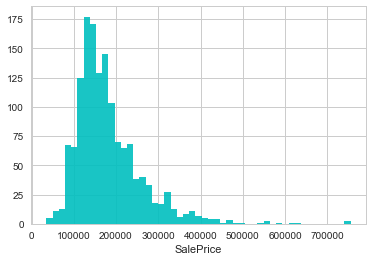

In [17]:
#It seems that SalePrice is skewered, so it needs to be transformed.
sns.distplot(data['SalePrice'], kde=False, color='c', hist_kws={'alpha': 0.9})

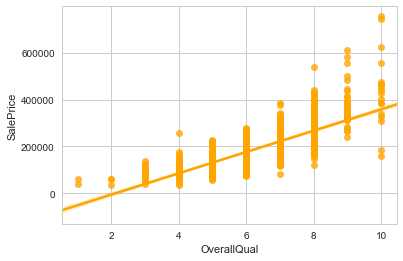

In [18]:
#As expected price rises with the quality.
sns.regplot(x='OverallQual', y='SalePrice', data=data, color='Orange')

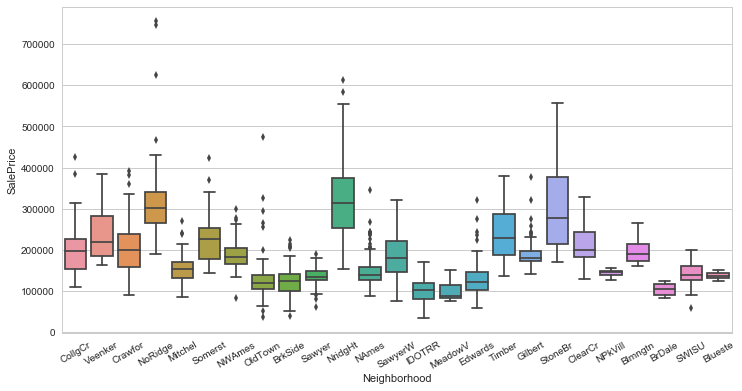

In [19]:
#Price also varies depending on neighborhood.
plt.figure(figsize = (12, 6))
sns.boxplot(x='Neighborhood', y='SalePrice',  data=data)
xt = plt.xticks(rotation=30)

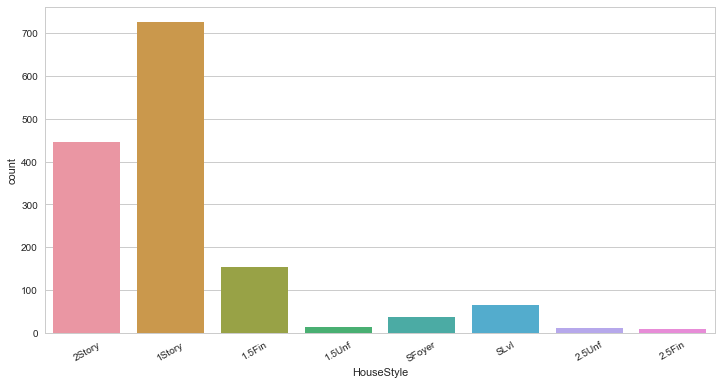

In [20]:
#There are many little houses.
plt.figure(figsize = (12, 6))
sns.countplot(x='HouseStyle', data=data)
xt = plt.xticks(rotation=30)

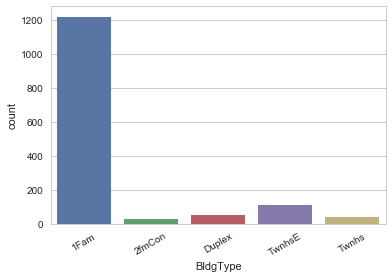

In [21]:
#And most of the houses are single-family, so it isn't surprising that most of the them aren't large.
sns.countplot(x='BldgType', data=data)
xt = plt.xticks(rotation=30)

In [22]:
#Most of fireplaces are of good or average quality. And nearly half of houses don't have fireplaces at all.
pd.crosstab(data.Fireplaces, data.FireplaceQu)

FireplaceQu,Ex,Fa,Gd,None,Po,TA
Fireplaces,,,,,,
0,0,0,0,690,0,0
1,19,28,324,0,20,259
2,4,4,54,0,0,53
3,1,1,2,0,0,1


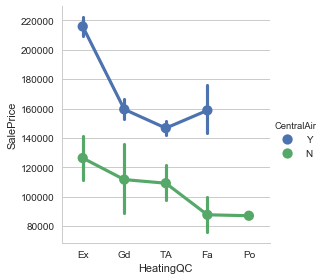

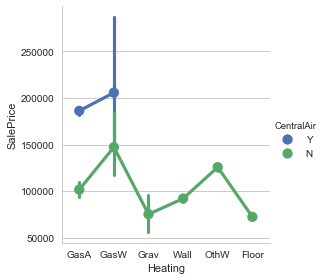

In [23]:
sns.factorplot('HeatingQC', 'SalePrice', hue='CentralAir', data=data)
sns.factorplot('Heating', 'SalePrice', hue='CentralAir', data=data)

Houses with central air conditioning cost more. And it is interesting that houses with poor and good heating quality cost
nearly the same if they have central air conditioning. Also only houses with gas heating have central air conditioning.

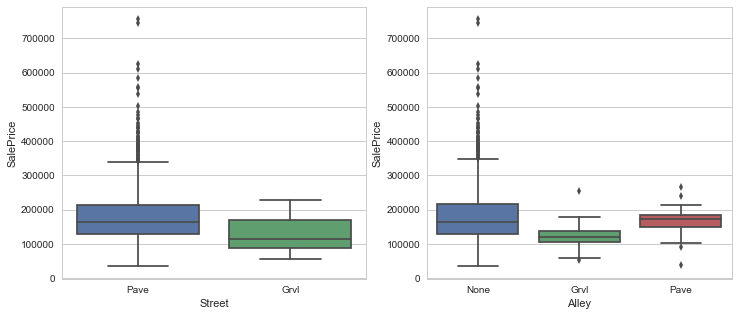

In [24]:
#One more interesting point is that while pavement road access is valued more, for alley they quality isn't that important.
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.boxplot(x='Street', y='SalePrice', data=data, ax=ax[0])
sns.boxplot(x='Alley', y='SalePrice', data=data, ax=ax[1])

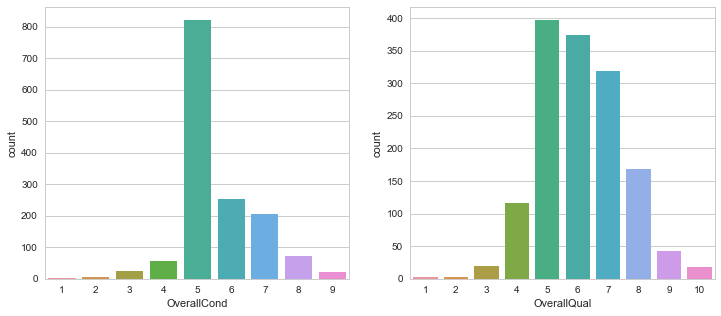

In [25]:
#We can say that while quality is normally distributed, overall condition of houses is mainly average.
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.countplot(x='OverallCond', data=data, ax=ax[0])
sns.countplot(x='OverallQual', data=data, ax=ax[1])

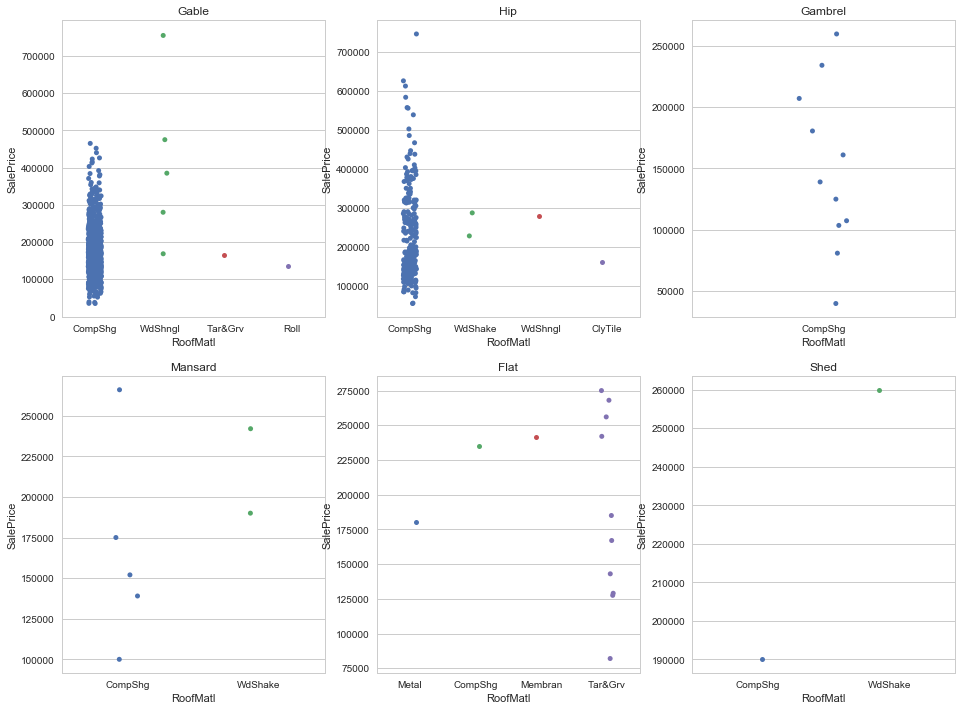

In [26]:
fig, ax = plt.subplots(2, 3, figsize = (16, 12))
ax[0,0].set_title('Gable')
ax[0,1].set_title('Hip')
ax[0,2].set_title('Gambrel')
ax[1,0].set_title('Mansard')
ax[1,1].set_title('Flat')
ax[1,2].set_title('Shed')
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Gable'], jitter=True, ax=ax[0,0])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Hip'], jitter=True, ax=ax[0,1])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Gambrel'], jitter=True, ax=ax[0,2])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Mansard'], jitter=True, ax=ax[1,0])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Flat'], jitter=True, ax=ax[1,1])
sns.stripplot(x="RoofMatl", y="SalePrice", data=data[data.RoofStyle == 'Shed'], jitter=True, ax=ax[1,2])

These graphs show information about roof materials and style. Most houses have Gable and Hip style. And material for most roofs is standard.

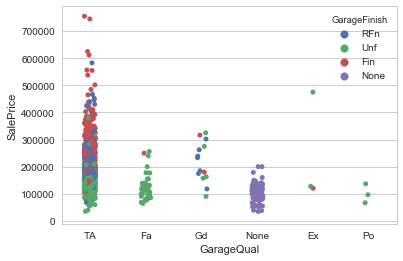

In [27]:
sns.stripplot(x="GarageQual", y="SalePrice", data=data, hue='GarageFinish', jitter=True)

Most finished garages gave average quality.

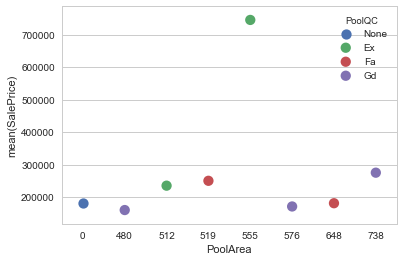

In [28]:
sns.pointplot(x="PoolArea", y="SalePrice", hue="PoolQC", data=data)

It is worth noting that there are only 7 different pool areas. And while for most of them mean price is ~200000-300000$, pools with area 555 cost very much. Let's see.

In [29]:
#There is only one such pool and sale condition for it is 'Abnorml'.
data.loc[data.PoolArea == 555]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


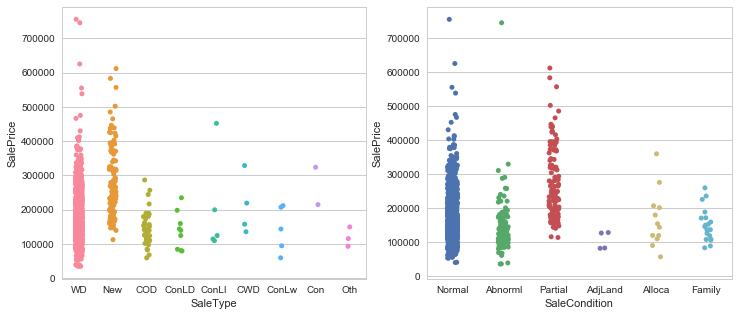

In [30]:
fig, ax = plt.subplots(1, 2, figsize = (12, 5))
sns.stripplot(x="SaleType", y="SalePrice", data=data, jitter=True, ax=ax[0])
sns.stripplot(x="SaleCondition", y="SalePrice", data=data, jitter=True, ax=ax[1])

Most of the sold houses are either new or sold under Warranty Deed. And only a little number of houses are sales between family, adjoining land purchases or allocation.

## <a name="datprep">Data preparation</a>

In [31]:
#MSSubClass shows codes for the type of dwelling, it is clearly a categorical variable.
data['MSSubClass'].unique()

array([ 60,  20,  70,  50, 190,  45,  90, 120,  30,  85,  80, 160,  75,
       180,  40], dtype=int64)

In [32]:
data['MSSubClass'] = data['MSSubClass'].astype(str)
test['MSSubClass'] = test['MSSubClass'].astype(str)

Transforming skewered data and dummifying categorical.

In [33]:
for col in data.columns:
    if data[col].dtype != 'object':
        if skew(data[col]) > 0.75:
            data[col] = np.log1p(data[col])
        pass
    else:
        dummies = pd.get_dummies(data[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        data.drop(col, axis=1, inplace=True)
        data = data.join(dummies)
        
for col in test.columns:
    if test[col].dtype != 'object':
        if skew(test[col]) > 0.75:
            test[col] = np.log1p(test[col])
        pass
    else:
        dummies = pd.get_dummies(test[col], drop_first=False)
        dummies = dummies.add_prefix("{}_".format(col))
        test.drop(col, axis=1, inplace=True)
        test = test.join(dummies)

Maybe a good idea would be to create some new features, but I decided to do without it. It is time-consuming and model is good enough without it. Besides, the number of features if quite high already.

In [34]:
#This is how the data looks like now.
data.head()

,Id,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
0,1,4.189655,9.042040,7,5,2003,2003,5.283204,6.561031,0.0,...,0,0,0,1,0,0,0,0,1,0
1,2,4.394449,9.169623,6,8,1976,1976,0.000000,6.886532,0.0,...,0,0,0,1,0,0,0,0,1,0
2,3,4.234107,9.328212,7,5,2001,2002,5.093750,6.188264,0.0,...,0,0,0,1,0,0,0,0,1,0
3,4,4.110874,9.164401,7,5,1915,1970,0.000000,5.379897,0.0,...,0,0,0,1,1,0,0,0,0,0
4,5,4.442651,9.565284,8,5,2000,2000,5.860786,6.486161,0.0,...,0,0,0,1,0,0,0,0,1,0


In [35]:
X_train = data.drop('SalePrice',axis=1)
Y_train = data['SalePrice']
X_test  = test

## <a name="model">Model</a>

In [36]:
#Function to measure accuracy.
def rmlse(val, target):
    return np.sqrt(np.sum(((np.log1p(val) - np.log1p(np.expm1(target)))**2) / len(target)))

In [37]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_train, Y_train, test_size=0.33)

I'll try several models.

Ridge is linear least squares model with l2 regularization (using squared difference).

RidgeCV is Ridge regression with built-in cross-validation.

Lasso is Linear Model trained with l1 regularization (using module).

LassoCV is Lasso linear model with iterative fitting along a regularization path.

Random Forest is usually good in cases with many features.

And XGBoost is a library which is very popular lately and usually gives good results.

In [38]:
ridge = Ridge(alpha=10, solver='auto').fit(Xtrain, ytrain)
val_ridge = np.expm1(ridge.predict(Xtest))
rmlse(val_ridge, ytest)

0.13346260272941882

In [39]:
ridge_cv = RidgeCV(alphas=(0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
ridge_cv.fit(Xtrain, ytrain)
val_ridge_cv = np.expm1(ridge_cv.predict(Xtest))
rmlse(val_ridge_cv, ytest)

0.13346260273214372

In [40]:
las = linear_model.Lasso(alpha=0.0005).fit(Xtrain, ytrain)
las_ridge = np.expm1(las.predict(Xtest))
rmlse(las_ridge, ytest)

0.12607216571928639

In [41]:
las_cv = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
las_cv.fit(Xtrain, ytrain)
val_las_cv = np.expm1(las_cv.predict(Xtest))
rmlse(val_las_cv, ytest)

D:\Programs\Anaconda3\lib\site-packages\sklearn\linear_model\coordinate_descent.py:484: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


0.12607216571928639

In [42]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2) #the params were tuned using xgb.cv
model_xgb.fit(Xtrain, ytrain)
xgb_preds = np.expm1(model_xgb.predict(Xtest))
rmlse(xgb_preds, ytest)

0.13385573967805864

In [43]:
forest = RandomForestRegressor(min_samples_split =5,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = None,
                                max_depth = None,
                                n_estimators = 300,
                                max_features = 'auto')

forest.fit(Xtrain, ytrain)
Y_pred_RF = np.expm1(forest.predict(Xtest))
rmlse(Y_pred_RF, ytest)

0.15645551722765741

So linear models perform better than the others. And lasso is the best.

Lasso model has one nice feature - it provides feature selection, as it assignes zero weights to the least important variables.

In [44]:
coef = pd.Series(las_cv.coef_, index = X_train.columns)
v = coef.loc[las_cv.coef_ != 0].count() 
print('So we have ' + str(v) + ' variables')

So we have 126 variables


In [45]:
#Basically I sort features by weights and take variables with max weights.
indices = np.argsort(abs(las_cv.coef_))[::-1][0:v]

In [46]:
#Features to be used. I do this because I want to see how good will other models perform with these features.
features = X_train.columns[indices]
for i in features:
    if i not in X_test.columns:
        print(i)

RoofMatl_ClyTile


There is only one selected feature which isn't in test data. I'll simply add this column with zero values.

In [47]:
X_test['RoofMatl_ClyTile'] = 0

In [48]:
X = X_train[features]
Xt = X_test[features]

Let's see whether something changed.

In [49]:
Xtrain1, Xtest1, ytrain1, ytest1 = train_test_split(X, Y_train, test_size=0.33)

In [50]:
ridge = Ridge(alpha=5, solver='svd').fit(Xtrain1, ytrain1)
val_ridge = np.expm1(ridge.predict(Xtest1))
rmlse(val_ridge, ytest1)

0.11924552653155912

In [51]:
las_cv = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10)).fit(Xtrain1, ytrain1)
val_las = np.expm1(las_cv.predict(Xtest1))
rmlse(val_las, ytest1)

0.11565867162196054

In [52]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.2) #the params were tuned using xgb.cv
model_xgb.fit(Xtrain1, ytrain1)
xgb_preds = np.expm1(model_xgb.predict(Xtest1))
rmlse(xgb_preds, ytest1)

0.12409445447687704

In [53]:
forest = RandomForestRegressor(min_samples_split =5,
                                min_weight_fraction_leaf = 0.0,
                                max_leaf_nodes = None,
                                max_depth = 100,
                                n_estimators = 300,
                                max_features = None)

forest.fit(Xtrain1, ytrain1)
Y_pred_RF = np.expm1(forest.predict(Xtest1))
rmlse(Y_pred_RF, ytest1)

0.1461884843752316

The accuracy got worse, but it is due to random seed while splitting the data. It's time for prediction!

In [54]:
las_cv1 = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
las_cv1.fit(X, Y_train)
lasso_preds = np.expm1(las_cv1.predict(Xt))

In [55]:
#I added XGBoost as it usually improves the predictions.
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.1)
model_xgb.fit(X, Y_train)
xgb_preds = np.expm1(model_xgb.predict(Xt))

In [56]:
preds = 0.7 * lasso_preds + 0.3 * xgb_preds

In [57]:
submission = pd.DataFrame({
        'Id': test['Id'].astype(int),
        'SalePrice': preds
    })
submission.to_csv('home.csv', index=False)

But the result wasn't very good. I thought for some time and then decided that the problem could lie in feature selection - maybe I selected bad features or Maybe random seed gave bad results. I decided to try selecting features based on full training dataset (not just on part of the data).

In [58]:
model_lasso = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10, 100))
model_lasso.fit(X_train, Y_train)
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
v1 = coef.loc[model_lasso.coef_ != 0].count()
print('So we have ' + str(v1) + ' variables')

So we have 120 variables


In [59]:
indices = np.argsort(abs(model_lasso.coef_))[::-1][0:v1]
features_f=X_train.columns[indices]

In [60]:
print('Features in full, but not in val:')
for i in features_f:
    if i not in features:
        print(i)
print('\n' + 'Features in val, but not in full:')
for i in features:
    if i not in features_f:
        print(i)

Features in full, but not in val:
1stFlrSF
GarageCond_Fa
SaleType_New
Functional_Maj2
Foundation_BrkTil
MSSubClass_120
SaleType_COD
LandSlope_Mod
SaleCondition_Family
KitchenQual_TA
LotShape_IR1
Heating_Grav
MasVnrType_BrkCmn
BsmtFinType1_Rec
BedroomAbvGr
HeatingQC_TA
Exterior2nd_VinylSd
MasVnrType_Stone

Features in val, but not in full:
SaleCondition_Partial
LandSlope_Gtl
Neighborhood_MeadowV
Alley_None
MSZoning_RL
LandContour_Lvl
MSSubClass_60
BsmtFinType1_GLQ
Foundation_CBlock
SaleType_ConLD
Exterior2nd_HdBoard
Exterior2nd_Wd Shng
BsmtQual_Fa
BsmtFinType1_BLQ
BsmtFinType2_ALQ
Electrical_SBrkr
BsmtFinType1_ALQ
Neighborhood_Gilbert
SaleCondition_Alloca
ExterQual_Gd
BsmtCond_TA
Fence_None
HeatingQC_Gd
LotShape_Reg


A lot of difference between the selected features. I suppose that the reason for this is that there was too little data relatively to the number of features in the first case. So I'll use the features obtain with the analysis of the whole train dataset.

In [61]:
for i in features_f:
    if i not in X_test.columns:
        X_test[i] = 0
        print(i)
X = X_train[features_f]
Xt = X_test[features_f]

Now all necessary features are present in both train and test.

In [62]:
model_lasso = LassoCV(alphas=(0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.3, 1, 3, 5, 10))
model_lasso.fit(X, Y_train)
lasso_preds = np.expm1(model_lasso.predict(Xt))

In [63]:
model_xgb = xgb.XGBRegressor(n_estimators=340, max_depth=2, learning_rate=0.1) #the params were tuned using xgb.cv
model_xgb.fit(X, Y_train)
xgb_preds = np.expm1(model_xgb.predict(Xt))

In [64]:
solution = pd.DataFrame({"id":test.Id, "SalePrice":0.7*lasso_preds + 0.3*xgb_preds})
solution.to_csv("House_price.csv", index = False)

The best result I got with this model was 0.12922. Currently top results are 0.10-0.11.